In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
# plt.rcParams['text.usetex'] = True
# plt.rc('font', **font)


## hosing protocol

For an approximate protocol I am looking at Jackson 2022 (Understanding AMOC stability: the North Atlantic Hosing Model Intercomparison Project).

I propose the following: an idealized experiment with preindustrial co2 (spun up from GCB2024 B/D spinup and looping forcing (so, the GCB “B” run). with 50 years of uniform hosing applied (from Jackson:

“(uniform hosing from 50◦N to the Bering Strait), and use a hosing strength of 0.3 Sv”) “Tier 1 (highest priority) experiments are a hosing experiment of 0.3 Sv (which should be continued for at least 50 years), and recovery experiments with no hosing spun off from years 20 and 50 of the hosing experiment. These should be run for 100 years unless the AMOC immediately starts recovering, in which case 50 years is sufficient.”)



1.4859943287815122e-08
1.4859943287815122e-05


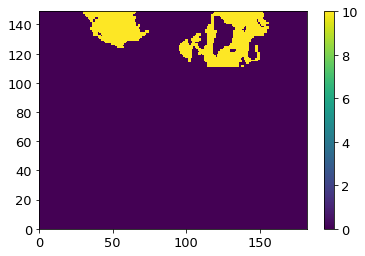

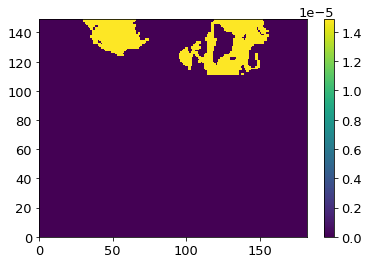

In [4]:
tgrid = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')

array = tgrid['tmask'][0,0,:,:]
hosar = np.copy(tgrid['tmask'][0,0,:,:])
hosar[111:150,79:156] = 10
hosar[124:150,20:80] = 10
hosar[np.where(array == 0)] = 0
hosar[np.where(hosar == 1)] = 0
tgrid_m2 = tgrid['tmask'][0,0,:,:] * tgrid['e1t'][0,:,:]\
* tgrid['e2t'][0,:,:]
tgrid_m2 = tgrid_m2.values
tgrid_m2[hosar < 6] = 0
plt.figure()
w = plt.pcolormesh(hosar)
plt.colorbar(w)

tot_ar = (np.sum(tgrid_m2))
hosing = 0.3 * 1e6
hosing_m = hosing/(np.sum(tot_ar))
print(hosing_m)
hosing_kg = hosing_m * 1e3
print(hosing_kg)

hosar_val = np.copy(hosar).astype(float)
hosar_val[hosar > 0] = hosing_kg
plt.figure()
w = plt.pcolormesh(hosar_val)
plt.colorbar(w)


## add hosing to 1990
hosar_val_broad = np.zeros([365,149, 182])

for i in range(0,365):
    hosar_val_broad[i,:,:] = hosar_val
    
hosar_val_broad366 = np.zeros([366,149, 182])

for i in range(0,366):
    hosar_val_broad366[i,:,:] = hosar_val


    
# odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
# ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosing/'
# w = xr.open_dataset(f'{odir}/era5_bulk_13_y1990.nc', decode_times=False)

# w['prra'].data = w['prra'].values + hosar_val_broad

# w.to_netcdf(f'{ndir}/era5_bulk_13_y1990.nc')
#prra:units = "kg/m^2/s" 

hos = False
if hos:

    for yr in range(1940,2024):
        odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
        ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosingArun/'
        w = xr.open_dataset(f'{odir}/era5_bulk_13_y{yr}.nc', decode_times=False)

        try:
            w['prra'].data = w['prra'].values + hosar_val_broad
        except:
            print(f'leap? {yr}')
            w['prra'].data = w['prra'].values + hosar_val_broad366
        w.to_netcdf(f'{ndir}/era5_bulk_13_y{yr}.nc')

## symlink forcing - hosing

In [5]:
import os

tdirs = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
tdir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosingArun/'

link = False

if link:
    
    print('testing tym socialne divergentni')
    
    for y in range(1940,2100):
        print(y)
        for b in range(8,16):
            if (b != 13):
                try:
                    src = f'{tdirs}era5_bulk_{b}_y{y}.nc'
                    dst = f'{tdir}era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)
                    print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
                    
        # try:
        #     src = f'{tdir}era5_bulk_13_y{y}.nc'
        #     dst = f'{tdir}era5_bulk_13_y{y}.nc'
        #     os.symlink(src,dst)
        #     print(f'year {y} bulk variable {b} GO!')
        # except:
        #     print(f'didnt work for year {y} bulk variable {b}')
        try:
            src = f'{tdirs}taux_1d_{y}_daily.nc'
            dst = f'{tdir}taux_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} taux is off')
        try:
            src = f'{tdirs}tauy_1d_{y}_daily.nc'
            dst = f'{tdir}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} tauy is off')


    print('we have shutdown')


In [6]:
import os

tdirs = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
tdir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosing/'

link = False

if link:
    
    print('testing tym socialne divergentni')
    
    for y in range(1940,2100):
        print(y)
        for b in range(8,16):
            if (b != 13):
                try:
                    src = f'{tdirs}era5_bulk_{b}_y1990.nc'
                    dst = f'{tdir}era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)
                    print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
                    
        try:
            src = f'{tdir}era5_bulk_13_y1990.nc'
            dst = f'{tdir}era5_bulk_13_y{y}.nc'
            os.symlink(src,dst)
            print(f'year {y} bulk variable {b} GO!')
        except:
            print(f'didnt work for year {y} bulk variable {b}')
        try:
            src = f'{tdirs}taux_1d_1990_daily.nc'
            dst = f'{tdir}taux_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} taux is off')
        try:
            src = f'{tdirs}tauy_1d_1990_daily.nc'
            dst = f'{tdir}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} tauy is off')


    print('we have shutdown')


In [7]:
import os

tdirs = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
tdir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosing1967/'

link = False

if link:
    
    print('testing tym socialne divergentni')
    
    for y in range(1940,2100):
        print(y)
        for b in range(8,16):
            if (b != 13):
                try:
                    src = f'{tdirs}era5_bulk_{b}_y1967.nc'
                    dst = f'{tdir}era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)
                    print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
                    
        try:
            src = f'{tdir}era5_bulk_13_y1967.nc'
            dst = f'{tdir}era5_bulk_13_y{y}.nc'
            os.symlink(src,dst)
            print(f'year {y} bulk variable {b} GO!')
        except:
            print(f'didnt work for year {y} bulk variable {b}')
        try:
            src = f'{tdirs}taux_1d_1967_daily.nc'
            dst = f'{tdir}taux_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} taux is off')
        try:
            src = f'{tdirs}tauy_1d_1967_daily.nc'
            dst = f'{tdir}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} tauy is off')


    print('we have shutdown')


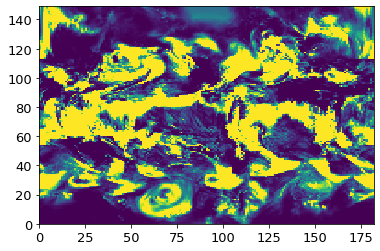

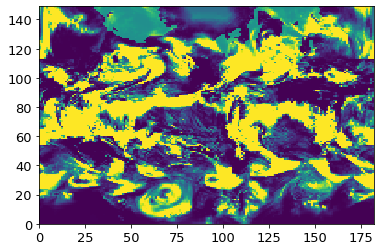

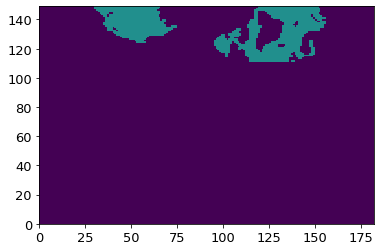

In [8]:

odir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'
ndir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/hosing/'


w1 = xr.open_dataset(f'{odir}/era5_bulk_13_y1990.nc', decode_times=False)
w2 = xr.open_dataset(f'{ndir}/era5_bulk_13_y1990.nc', decode_times=False)


plt.figure()
plt.pcolormesh(w1.prra[0,:,:], vmin = 0, vmax = 3e-5)
plt.figure()
plt.pcolormesh(w2.prra[0,:,:], vmin = 0, vmax = 3e-5)
plt.figure()
plt.pcolormesh(w2.prra[0,:,:]-w1.prra[0,:,:], vmin = 0, vmax = 3e-5)

## experiment overview

see https://www.notion.so/hosing-experiment-5833649ed7784b57b65b8c69f49d2f11

SR - sal rest

model | desc |
-- | -- |
R4B0 | SR no hos |
RWB0 | no SR |
R4BH | SR, hosing |
RWBH | no SR, hosing |

In [9]:


def make_yearlist(yrst, yrend, tr, baseDir = '/gpfs/home/mep22dku/cdftools/MOCresults/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        tyr = yrs[i]
        ty = f'{baseDir}{tr}_1m_{tyr}0101*MOC.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def get_max_amoc(moc_dataset):

    atl_at_26 = np.squeeze(moc_dataset.zomsfatl.sel(y=94).values)
    tshape = np.shape(atl_at_26)
    len_ts = tshape[0]

    max_atl = np.zeros(len_ts)

    for i in range(0,len(max_atl)):
        max_atl[i] = np.nanmax(atl_at_26[i,:])
        
    return max_atl

R4B0_moc = make_yearlist(1940, 2023, 'TOM12_TJ_R4B0')
RWB0_moc = make_yearlist(1940, 2023, 'TOM12_TJ_RWB0')
RWBH_moc = make_yearlist(1940, 2023, 'TOM12_TJ_RWBH')
#R4BH_moc = make_yearlist(1959, 2023, 'TOM12_TJ_R4BH')

R4B0_mocdat = xr.open_mfdataset(R4B0_moc) 
RWB0_mocdat = xr.open_mfdataset(RWB0_moc) 
RWBH_mocdat = xr.open_mfdataset(RWBH_moc) 
nicetime  = R4B0_mocdat.indexes['time_counter'].to_datetimeindex()

#R4BH_mocdat = xr.open_mfdataset(R4BH_moc) 

R4B0_max_amoc = get_max_amoc(R4B0_mocdat)
RWB0_max_amoc = get_max_amoc(RWB0_mocdat)
RWBH_max_amoc = get_max_amoc(RWBH_mocdat)
#R4BH_max_amoc = get_max_amoc(R4BH_mocdat)

In [10]:
data_vars = {'amoc':(['time_counter'], R4B0_max_amoc,),}
coords = {'time_counter': (['time_counter'], nicetime)}
R4B0_max = xr.Dataset(data_vars=data_vars,coords=coords)

data_vars = {'amoc':(['time_counter'], RWB0_max_amoc,),}
RWB0_max = xr.Dataset(data_vars=data_vars,coords=coords)

data_vars = {'amoc':(['time_counter'], RWBH_max_amoc,),}
RWBH_max = xr.Dataset(data_vars=data_vars,coords=coords)

# data_vars = {'amoc':(['time_counter'], R4BH_max_amoc,),}
# R4BH_max = xr.Dataset(data_vars=data_vars,coords=coords)

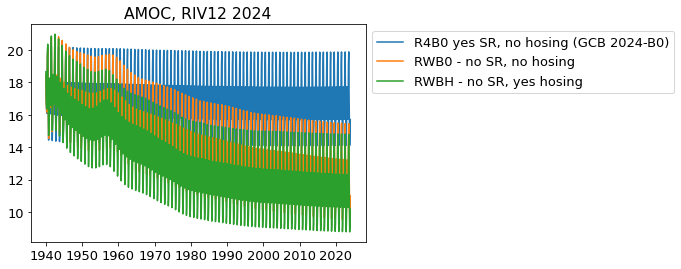

In [18]:
nicetime  = R4B0_mocdat.indexes['time_counter'].to_datetimeindex()

plt.plot(nicetime, R4B0_max.amoc, label = 'R4B0 yes SR, no hosing (GCB 2024-B0)')
plt.plot(nicetime, RWB0_max.amoc, label = 'RWB0 - no SR, no hosing')
plt.plot(nicetime, RWBH_max.amoc, label = 'RWBH - no SR, yes hosing')
#plt.plot(nicetime, R4BH_max_amoc, label = 'yes SR, yes hosing')
plt.title('AMOC, RIV12 2024')
#plt.ylim([14,24])
plt.legend(bbox_to_anchor = [1,1])

## make hosing forcing for flux-corrected runs

In [19]:

def make_hosing_forcing(tdirs, tdir):

    "symlinks files from one forcing directory to other, \
    adds HOSEMIP hosing to rain field, 1940-2024, \
    non-rain/snow fields come from ERA5"
    
    
    tdirE = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'

    for yr in range(1940,2024):
        w = xr.open_dataset(f'{tdirs}/era5_bulk_13_y{yr}.nc', decode_times=False)

        try:
            w['prra'].data = w['prra'].values + hosar_val_broad
        except:
            print(f'leap? {yr}')
            w['prra'].data = w['prra'].values + hosar_val_broad366
        w.to_netcdf(f'{tdir}/era5_bulk_13_y{yr}.nc')
        
    
    
    print('linking remaining forcing')
    
    for y in range(1940,2024):
        print(y)
        for b in range(14,15):
            if ((b == 14)):
                try:
                    src = f'{tdirs}era5_bulk_{b}_y{y}.nc'
                    dst = f'{tdir}era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)
                    print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')
    
    print('linking remaining forcing')
    
    for y in range(1940,2024):
        print(y)
        for b in range(8,16):
            if ((b != 13) & (b != 14)):
                try:
                    src = f'{tdirE}era5_bulk_{b}_y{y}.nc'
                    dst = f'{tdir}era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)
                    print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')

        try:
            src = f'{tdirE}taux_1d_y{y}.nc'
            dst = f'{tdir}taux_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print(f'year {y} taux is off')
        try:
            src = f'{tdirE}tauy_1d_y{y}.nc'
            dst = f'{tdir}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print(f'year {y} tauy is off')


    print('we have shutdown')


In [20]:
import os

def symlink_before_1940(tdirs, tdir, syear = 1920):

    tdirE = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/'


    for y in range(syear,1940):
        print(y)
        for b in range(13,15):

            try:
                src = f'{tdirs}era5_bulk_{b}_y{y}.nc'
                dst = f'{tdir}era5_bulk_{b}_y{y}.nc'
                os.symlink(src,dst)
                print(f'year {y} bulk variable {b} GO!')
            except:
                print(f'didnt work for year {y} bulk variable {b}')
    
    
    for y in range(syear,1940):
        print(y)
        for b in range(8,16):
            if ((b != 13) & (b != 14)):
                try:
                    src = f'{tdirE}era5_bulk_{b}_y{y}.nc'
                    dst = f'{tdir}era5_bulk_{b}_y{y}.nc'
                    os.symlink(src,dst)
                    print(f'year {y} bulk variable {b} GO!')
                except:
                    print(f'didnt work for year {y} bulk variable {b}')

        try:
            src = f'{tdirE}taux_1d_y{y}.nc'
            dst = f'{tdir}taux_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} taux is off')
        try:
            src = f'{tdirE}tauy_1d_y{y}.nc'
            dst = f'{tdir}tauy_1d_y{y}.nc'
            os.symlink(src,dst)
        except:
            print('year {y} tauy is off')


    print('we have shutdown')


In [21]:
tdirs = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0/'
tdir = '/gpfs/data/greenocean/software/products/ERA5_v202303_TJ/fc_glob5pt0-HOSE/'

make_hosing_forcing(tdirs, tdir)
symlink_before_1940(tdirs, tdir, syear = 1920)

leap? 1940
leap? 1944
leap? 1948
leap? 1952
leap? 1956
leap? 1960
leap? 1964
leap? 1968
leap? 1972
leap? 1976
leap? 1980
leap? 1984
leap? 1988
leap? 1992
leap? 1996
leap? 2000
leap? 2004
leap? 2008
leap? 2012
leap? 2016
leap? 2020
linking remaining forcing
1940
year 1940 bulk variable 14 GO!
1941
year 1941 bulk variable 14 GO!
1942
year 1942 bulk variable 14 GO!
1943
year 1943 bulk variable 14 GO!
1944
year 1944 bulk variable 14 GO!
1945
year 1945 bulk variable 14 GO!
1946
year 1946 bulk variable 14 GO!
1947
year 1947 bulk variable 14 GO!
1948
year 1948 bulk variable 14 GO!
1949
year 1949 bulk variable 14 GO!
1950
year 1950 bulk variable 14 GO!
1951
year 1951 bulk variable 14 GO!
1952
year 1952 bulk variable 14 GO!
1953
year 1953 bulk variable 14 GO!
1954
year 1954 bulk variable 14 GO!
1955
year 1955 bulk variable 14 GO!
1956
year 1956 bulk variable 14 GO!
1957
year 1957 bulk variable 14 GO!
1958
year 1958 bulk variable 14 GO!
1959
year 1959 bulk variable 14 GO!
1960
year 1960 bulk var